In [1]:
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import astropy.units as u
import numpy as np
import sed_analysis_tools as st

# Filter systems

In [ ]:
# optimistic filters
x_optimistic = 10**np.linspace(3.13, 4.70, 50) * u.Angstrom
filter_set_optimistic = st.FilterSet(list_pivot_wavelengths=x_optimistic)
# realistic filters
x_realistic = 10**np.linspace(3.13, 4.70, 15) * u.Angstrom
filter_set_realistic = st.FilterSet(list_pivot_wavelengths=x_realistic)

# gaia xp filters
'''
https://gea.esac.esa.int/archive/documentation/GDR3/Gaia_archive/chap_datamodel/sec_dm_spectroscopic_tables/ssec_dm_xp_sampled_mean_spectrum.html
'''
x_gaia = (10*np.linspace(336,1020, 343)) * u.Angstrom
filter_set_gaia = st.FilterSet(list_pivot_wavelengths=x_gaia)

# uocs filters
x_uocs=np.log10([1481,1541,1608, #UVIT
                 2196,2418,2447,2632, #UVIT
                 1548,2303, #GALEX
                 5041,5850,5850, #Gaia
                 3608,4671,6141,7457,8922,#SDSS
                 12350,16620,21590, #2MASS
                 33526,46028,115608,220883 #WISE
                ]) * u.Angstrom
filter_set_uocs = st.FilterSet(list_pivot_wavelengths=x_uocs)

# optical-IR filters
x_optical_IR=([5041,5850,5850, #Gaia
                 3608,4671,6141,7457,8922,#SDSS
                 12350,16620,21590, #2MASS
                 33526,46028,115608,220883 #WISE
                ]) * u.Angstrom
filter_set_optical_IR = st.FilterSet(list_pivot_wavelengths=x_optical_IR)

# Analysing single stars' recovery

In [3]:
importlib.reload(st)

logT_A_list = np.linspace(3.5,5.1,9)
logL_A_list = np.full(len(logT_A_list),0)
frac_err_list = np.logspace(-4,0,9)[:-1]
niter = 50

fit_params = []
for idx, _logT in tqdm(enumerate(logT_A_list[:])):
    for jdx, frac_err in enumerate(frac_err_list[:]):
        for seed in range(niter):
            index = jdx+len(frac_err_list)*idx
            star = st.Star(T = 10**_logT *u.K, 
                        L = 1 *u.solLum, 
                        frac_err=frac_err,
                        name='T%.2f_sigma%.4f_single'%(_logT,frac_err),
                        filter_set=filter_set_optimistic,
                        seed=seed)
            star.fit_bb_Single(use_priors=True)

            logT_Single = star.logT_Single if hasattr(star, 'logT_Single') else np.nan
            logL_Single = star.logL_Single if hasattr(star, 'logL_Single') else np.nan
            _fit_params_Single = dict(name=star.name,
                            seed=star.seed,
                            logT=star.logT,
                            logL=star.logL,
                            logT_Single=logT_Single,
                            logL_Single=logL_Single,
                            sigma = frac_err)
            fit_params.append(_fit_params_Single)

df_fit_params = pd.DataFrame(fit_params)

8it [00:42,  5.36s/it]/vol/aibn182/data1/vjadhav/2024_binary_identification/run_4/sed_analysis_tools.py:1810: UserWarning: T5.10_sigma0.3162_single: Fit rejected due to being close to the parameter (T, logsf) boundary.
  Fitter.bb_Single(source=self, p0=p0, **kwargs)
9it [00:48,  5.35s/it]


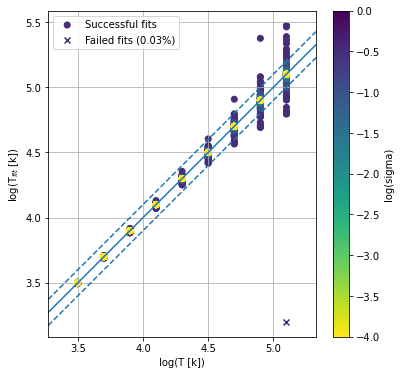

In [4]:
df_fit_params.sort_values(by='sigma', inplace=True, ascending=False)
_filter = (~np.isfinite(df_fit_params.logT_Single))
fig, ax = plt.subplots(figsize=(6,6))
kwargs=dict(cmap='viridis_r', alpha=1, vmin=-4, vmax=0)
p0 = ax.scatter(df_fit_params.logT, df_fit_params.logT_Single, c=np.log10(df_fit_params.sigma),
                marker='o', label='Successful fits', **kwargs)
p1 = ax.scatter(df_fit_params.logT[_filter], np.full(len(df_fit_params),3.2)[_filter], 
                c=np.log10(df_fit_params.sigma[_filter]),
                marker='x', label=f'Failed fits ({100*sum(_filter)/len(_filter):,.2f}%)', **kwargs)
ax.axline((4,4),slope=1)
ax.axline((4,4.1),slope=1, ls='--')
ax.axline((4,3.9),slope=1, ls='--')
ax.set(xlabel='log(T [k])', ylabel='log(T$_{fit}$ [k])')
ax.set_aspect('equal', adjustable='datalim')
plt.colorbar(p0, label='log(sigma)')
ax.grid()
ax.legend()

# Analysing a general grid of temperature (Section 3)
⚠️ ⚠️ Running the grids may take >2 hours/cell for rest of the notebook due to the large number of models. ⚠ ⚠

[0.0001     0.00031623 0.001      0.00316228 0.01       0.03162278
 0.1       ] 
 [3.5 3.7 3.9 4.1 4.3 4.5 4.7 4.9 5.1] 
 [0 0 0 0 0 0 0 0 0]
63


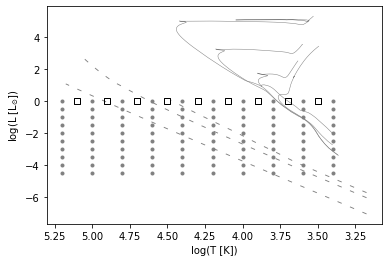

In [5]:
logT_A_list = np.linspace(3.5,5.1,9)
logL_A_list = np.full(len(logT_A_list),0)
frac_err_list = np.logspace(-4,0,9)[:-2]

logT_B_list = np.linspace(3.4,5.2,10)
logL_B_list = np.linspace(-4.5,0,10)
logT_B_list, logL_B = np.meshgrid(logT_B_list, logL_B_list)
logT_B_list, logL_B_list = logT_B_list.flatten(), logL_B.flatten()

print(frac_err_list, '\n', logT_A_list, '\n', logL_A_list)
print(len(frac_err_list)*len(logT_A_list))
fig, ax = plt.subplots()
st.Plotter.plot_isochrone_and_wd(ax)
plt.scatter(logT_A_list, logL_A_list, marker='s', edgecolors='k',facecolor='none')
plt.scatter(logT_B_list, logL_B_list, marker='.', color='0.5')

### Grid with optimistic_filters

In [6]:
importlib.reload(st)
import warnings
warnings.filterwarnings("ignore")

for idx, _logT in tqdm(enumerate(logT_A_list[:])):
    for jdx, frac_err in enumerate(frac_err_list[:]):
        index = jdx+len(frac_err_list)*idx
        grid = st.Grid(T_A = 10**_logT *u.K, 
                    L_A = 1 *u.solLum, 
                    logT_B_list = logT_B_list, 
                    logL_B_list = logL_B_list, 
                    niter=50,
                    frac_err=frac_err,
                    name='T%.2f_sigma%.4f_optimistic'%(_logT,frac_err),
                    filter_set=filter_set_optimistic)
        grid.calculate_params(refit=False)
        grid.plot(plot_name='plots/HRDs/optimistic/%s.jpg'%grid.name)

0it [00:00, ?it/s]

9it [00:06,  1.38it/s]


### Grid with realistic_filters

In [7]:
importlib.reload(st)
import warnings
warnings.filterwarnings("ignore")

for idx, _logT in tqdm(enumerate(logT_A_list[:])):
    for jdx, frac_err in enumerate(frac_err_list[:]):
        index = jdx+len(frac_err_list)*idx
        grid = st.Grid(T_A = 10**_logT *u.K, 
                    L_A = 1 *u.solLum, 
                    logT_B_list = logT_B_list, 
                    logL_B_list = logL_B_list, 
                    niter=50,
                    frac_err=frac_err,
                    name='T%.2f_sigma%.4f_realistic'%(_logT,frac_err),
                    filter_set=filter_set_realistic)
        grid.calculate_params(refit=False)
        grid.plot(plot_name='plots/HRDs/realistic/%s.jpg'%grid.name)


9it [00:05,  1.73it/s]


### Grid with gaia_xp_filters

In [8]:
importlib.reload(st)
import warnings
warnings.filterwarnings("ignore")

for idx, _logT in tqdm(enumerate(logT_A_list[:])):
    for jdx, frac_err in enumerate(frac_err_list[:]):
        index = jdx+len(frac_err_list)*idx
        grid = st.Grid(T_A = 10**_logT *u.K, 
                    L_A = 1 *u.solLum, 
                    logT_B_list = logT_B_list, 
                    logL_B_list = logL_B_list, 
                    niter=50,
                    frac_err=frac_err,
                    name='T%.2f_sigma%.4f_gaia'%(_logT,frac_err),
                    filter_set=filter_set_gaia)
        grid.calculate_params(refit=False)
        grid.plot(plot_name='plots/HRDs/gaia/%s.jpg'%grid.name)

9it [00:18,  2.02s/it]


### Grid with uocs_filters

In [11]:
importlib.reload(st)
import warnings
warnings.filterwarnings("ignore")

for idx, _logT in tqdm(enumerate(logT_A_list[:])):
    for jdx, frac_err in enumerate(frac_err_list[:]):
        index = jdx+len(frac_err_list)*idx
        grid = st.Grid(T_A = 10**_logT *u.K, 
                    L_A = 1 *u.solLum, 
                    logT_B_list = logT_B_list, 
                    logL_B_list = logL_B_list, 
                    niter=50,
                    frac_err=frac_err,
                    name='T%.2f_sigma%.4f_uocs'%(_logT,frac_err),
                    filter_set=filter_set_uocs)
        grid.calculate_params(refit=False)
        # grid.plot(plot_name='plots/HRDs/uocs/%s.jpg'%grid.name)

9it [00:03,  2.65it/s]


### Grid with optical_IR_filters

In [10]:
importlib.reload(st)
import warnings
warnings.filterwarnings("ignore")

for idx, _logT in (enumerate(logT_A_list[:])):
    for jdx, frac_err in enumerate(frac_err_list[:]):
        index = jdx+len(frac_err_list)*idx
        grid = st.Grid(T_A = 10**_logT *u.K, 
                    L_A = 1 *u.solLum, 
                    logT_B_list = logT_B_list, 
                    logL_B_list = logL_B_list, 
                    niter=50,
                    frac_err=frac_err,
                    name='T%.2f_sigma%.4f_optIR'%(_logT,frac_err),
                    filter_set=filter_set_optical_IR)
        grid.calculate_params(refit=False)
        # grid.plot(plot_name='plots/HRDs/optIR/%s.jpg'%grid.name)


# Analysing unresolved binaries using Gaia XP spectra (Section 4)

[0.0001     0.00031623 0.001      0.00316228 0.01       0.03162278] 
 [0.9, 1.0, 1.2, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0] 
 [3.73130222 3.75960804 3.8041     3.8655     3.9765     4.04995976
 4.1042     4.18303567 4.24364719 4.2912     4.35817123 4.40974122] 
 [-0.3318039  -0.11695627  0.267       0.718       1.24        1.62019299
  1.926       2.39660155  2.74830951  3.025       3.45681497  3.76927827]
72


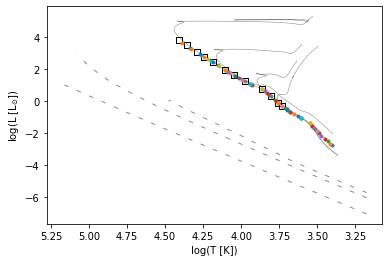

In [12]:
zams = pd.read_csv('/vol/aibn182/data1/vjadhav/models_and_tools/models/master_ZAMS.csv')
zams = zams[zams.MH==0].sort_values(by='Mass')

mass_list = [0.9,1.0,1.2,1.5,2.0,2.5,3.0,4.0,5.0,6.0,8.0,10.0]
logT_A_list = np.interp(np.log10(mass_list), np.log10(zams.Mass), zams.logTe)
logL_A_list = np.interp(np.log10(mass_list), np.log10(zams.Mass), zams.logL)
frac_err_list = np.logspace(-4,-1,7)[:-1]

print(frac_err_list, '\n', mass_list, '\n', logT_A_list, '\n', logL_A_list)
print(len(frac_err_list)*len(mass_list))

fig, ax = plt.subplots()
st.Plotter.plot_isochrone_and_wd(ax)
plt.scatter(logT_A_list, logL_A_list, marker='s', edgecolors='k',facecolor='none')
for mass in mass_list:
    secondary_mass_list = mass * np.array([0.1,0.3,0.5,0.7,0.9])
    logT_B_list = np.interp(np.log10(secondary_mass_list), np.log10(zams.Mass), zams.logTe)
    logL_B_list = np.interp(np.log10(secondary_mass_list), np.log10(zams.Mass), zams.logL)
    plt.scatter(logT_B_list, logL_B_list, marker='.')

In [13]:
importlib.reload(st)

for idx, mass in tqdm(enumerate(mass_list[:])):
    T_A = 10**logT_A_list[idx]
    L_A = 10**logL_A_list[idx]

    secondary_mass_list = mass * np.array([0.1,0.3,0.5,0.7,0.9])
    logT_B_list = np.interp(np.log10(secondary_mass_list), np.log10(zams.Mass), zams.logTe)
    logL_B_list = np.interp(np.log10(secondary_mass_list), np.log10(zams.Mass), zams.logL)
    
    for jdx, frac_err in enumerate(frac_err_list[:]):
        index = jdx+len(frac_err_list)*idx
        grid = st.Grid(T_A = T_A*u.K, 
                    L_A = L_A*u.solLum, 
                    niter=50,
                    frac_err=frac_err,
                    name='M%.2f_sigma%.4f_gaia'%(mass, frac_err),
                    logT_B_list=logT_B_list,
                    logL_B_list=logL_B_list,
                    filter_set=filter_set_gaia)
        grid.calculate_params(refit=False)
        grid.plot(plot_name='plots/HRDs/unresolved/%s.jpg'%grid.name)

0it [00:00, ?it/s]

12it [00:03,  3.59it/s]


# Analysing UOCS type hotter companions (Section 5)

[0.001      0.00316228 0.01       0.03162278 0.1       ] 
 [0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.5, 3.0] 
 [3.6961     3.75960804 3.8041     3.8421     3.8922     3.93910271
 3.9765     4.04995976 4.1042    ] 
 [-0.569      -0.11695627  0.267       0.583       0.842       1.05397301
  1.24        1.62019299  1.926     ]
45


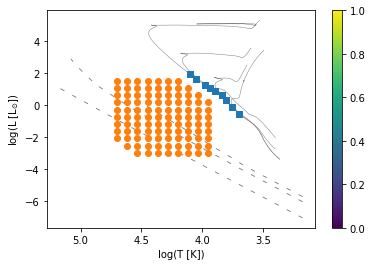

In [14]:
importlib.reload(st)

zams = zams[zams.MH==0].sort_values(by='Mass')

mass_list = [0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.5,3.0]
logT_A_list = np.interp(np.log10(mass_list), np.log10(zams.Mass), zams.logTe)
logL_A_list = np.interp(np.log10(mass_list), np.log10(zams.Mass), zams.logL)
frac_err_list = np.logspace(-3,-1,5)[:]

print(frac_err_list, '\n', mass_list, '\n', logT_A_list, '\n', logL_A_list)
print(len(frac_err_list)*len(mass_list))

logT_B_list = np.linspace(4.7,3.95,10)
logL_B_list = np.linspace(-3,1.5,11)
logT_B_list, logL_B_list = np.meshgrid(logT_B_list, logL_B_list)
i = np.indices(logT_B_list.shape)
_filter_1 = (i[0]+i[1]<17).flatten()
_filter_2 = (i[0]+i[1]>1).flatten()
_filter = (_filter_1&_filter_2)
logT_B_list = logT_B_list.flatten()[_filter]
logL_B_list = logL_B_list.flatten()[_filter]

fig, ax = plt.subplots()
st.Plotter.plot_isochrone_and_wd(ax=ax)
ax.scatter(logT_A_list,logL_A_list, marker='s')
p0 = ax.scatter(logT_B_list,logL_B_list)
plt.colorbar(p0)

### Hotter companions with uocs_filters

In [17]:
importlib.reload(st)
import warnings
warnings.filterwarnings("ignore")

for idx, mass in tqdm(enumerate(mass_list[:])):
    T_A = 10**logT_A_list[idx]
    L_A = 10**logL_A_list[idx]   
    _filter =  (logL_B_list <=logL_A_list[idx])
    for jdx, frac_err in enumerate(frac_err_list[:]):
        index = jdx+len(frac_err_list)*idx
        grid = st.Grid(T_A = T_A*u.K, 
                    L_A = L_A*u.solLum, 
                    niter=50,
                    frac_err=frac_err,
                    name='M%.2f_sigma%.4f_uocs'%(mass,frac_err),
                    logT_B_list=logT_B_list[_filter],
                    logL_B_list=logL_B_list[_filter],
                    filter_set=filter_set_uocs)
        grid.calculate_params(refit=False)
        grid.plot(plot_name='plots/HRDs/hotter_companion/%s.jpg'%grid.name)


0it [00:00, ?it/s]

9it [00:03,  2.56it/s]


### Hotter companions with optical_IR_filters

In [18]:
importlib.reload(st)
import warnings
warnings.filterwarnings("ignore")

for idx, mass in tqdm(enumerate(mass_list[:])):
    T_A = 10**logT_A_list[idx]
    L_A = 10**logL_A_list[idx]   
    _filter =  (logL_B_list <=logL_A_list[idx])
    for jdx, frac_err in enumerate(frac_err_list[:]):
        index = jdx+len(frac_err_list)*idx
        grid = st.Grid(T_A = T_A*u.K, 
                    L_A = L_A*u.solLum, 
                    niter=50,
                    frac_err=frac_err,
                    name='M%.2f_sigma%.4f_optIR'%(mass,frac_err),
                    logT_B_list=logT_B_list[_filter],
                    logL_B_list=logL_B_list[_filter],
                    filter_set=filter_set_optical_IR)
        grid.calculate_params(refit=False)
        grid.plot(plot_name='plots/HRDs/hotter_companion/%s.jpg'%grid.name)


9it [00:03,  2.71it/s]
